<a href="https://colab.research.google.com/github/Gaurav927/Adversial_AutoEncoder/blob/master/Variational_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [0]:
batch_size =64

train_dataset = datasets.MNIST(root='./MNIST/',train=True,download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='./MNIST/',train=False,download=True,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [0]:
# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()

torch.Size([64, 1, 28, 28])
torch.Size([64])


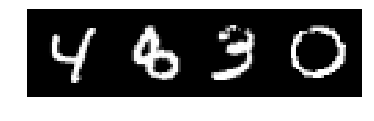

In [4]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[:4],nrow=4))

### In VAE we are trying to maximize the P(X) (i.e maximum likelihood estimation) 
#### **D[Q(z) || p(z|X)]** = **E<sub> ~Q(z)</sub>**[log(Q(z) - log(p(z|X)] 
#### p(z|X) = p(X|z)p(z)/p(X)
using above eqn in first eqn we get,
#### **D[Q(z) || p(z|X)]** = **E<sub> ~Q(z)</sub>**[log Q(z) - log(p(X|z)p(z)/p(X))]
#### **D[Q(z) || p(z|X)]** = **E<sub> ~Q(z)</sub>**[log Q(z) - log p(X|z) -log p(z) + log p(X)]
as P(X) is independent of z we get
#### **D[Q(z) || p(z|X)]** = **E<sub> ~Q(z)</sub>**[log Q(z) - log p(X|z) -log p(z) ] + log p(X)
#### **D[Q(z) || p(z|X)]** = **E<sub> ~Q(z)</sub>**[log Q(z) -log p(z) ] + log p(X) - **E<sub> ~Q(z)</sub>**log p(X|z) 
#### **D[Q(z) || p(z|X)]** =  **D[Q(z) || p(z)]** + log p(X) - **E<sub> ~Q(z)</sub>**log p(X|z) 
Further it can be rearranged to form, note Q(z|X)
#### **max(log p(x))** - D[Q(z|X) || p(z|X)] =  **D[Q(z|X) || p(z)]**  - **E<sub> ~Q(z)</sub>**log p(X|z) 
Note that p(z|X) is true distribution and we are trying to match this true distribution with Q(z|X) (Consider this as a Enoder). If Q(z|X) is well fitted, then we can ignore this as it contribution will be very less.So a now our objective function reduces to 
#### **max(log p(x))** =  **D[Q(z|X) || p(z)]**  - **E<sub> ~Q(z)</sub>**log p(X|z) 

### Objective func: **max(log p(x))** =  **D[Q(z|X) || p(z)]**  - **E<sub> ~Q(z)</sub>**log p(X|z) 
#### 1st term on the right hand side of the eqn
**Note that in first term we got both Q(z|X) and p(z) as normal distribution so KL- Divergence is easy to evaluate**
#### 2nd term on the right hand side of the eqn
**Note that, decoder is deterministic unlike encoder which outputs the mean and variance of the normal distribution and from there we sample data (z)<br />**
**Once we know z there is a corresponding x̅ , So the p(X|z) can be interpreted as p(X|x̅)**<br />
### p(X|x̅)  is Bernaulli or Gaussian distribution depending on the type of data we are modelling 
### **Resulting in Binary cross entropy loss or Reconstruction loss**

In [0]:
latent_dim =20
def generate_(batch_size):
    return torch.from_numpy(np.random.multivariate_normal(mean=np.zeros(latent_dim),cov =np.eye(latent_dim),size=batch_size)).type(torch.float)

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.layer1 = nn.Linear(784,400)
        self.mean = nn.Linear(400,latent_dim)
        self.variance = nn.Linear(400,latent_dim) ## Only diagonal element are non -zero
        self.layer2 = nn.Linear(20,400)
        self.layer3 = nn.Linear(400,784)
        
    def encode(self,x):
        x = F.relu(self.layer1(x))
        
        return self.mean(x),self.variance(x)
    def decode(self,z):
        z = F.relu(self.layer2(z))
        z = torch.sigmoid(self.layer3(z))
        return z
    
    def sample(self,mu,sigma):
        sigma = torch.exp(0.5*sigma).to(device) # To make variance greater than zero
        
        eps = generate_(batch_size).to(device)
        
        return mu + sigma*eps # Shifting the distribution X = mu + sigma*eps to desired dist.
    
    def forward(self,x):
        mu,sigma = self.encode(x)
        z = self.sample(mu,sigma).to(device)
        z = self.decode(z)
        return mu,sigma,z

In [0]:
## Assuming x|recon_x ~ normal distribution or x|recon_x ~ binomial
def Loss(mu,sigma,recon_x,x,normal=False):
    loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    error =0
    if(normal):
        error =  F.mse_loss(recon_x,x)
    else:
        error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return loss+error    

In [0]:
# Check availabilty of device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
num_epochs = 50
loss_list = []
for epoch in range(num_epochs):
    loss=0
    for i ,(images,target) in enumerate(train_loader):

        batch_size = images.size(0)
        images = images.view(batch_size, -1).to(device)
        images = Variable(images,requires_grad =False)

        
        # set grad to zero
        optimizer.zero_grad()
        
        # Model training and Loss calculation
        mu,sigma,z = model(images)
        i_loss = Loss(mu,sigma,z,images)
        loss+=i_loss.item()
        i_loss.backward()
        optimizer.step()
        # accuracy

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                      .format(epoch, num_epochs, i+1, 938, i_loss.item()))
    loss_list.append(loss)

Epoch [0/50], Step [200/938], Loss: 9766.3262
Epoch [0/50], Step [400/938], Loss: 8338.5322
Epoch [0/50], Step [600/938], Loss: 8235.2676
Epoch [0/50], Step [800/938], Loss: 7817.5098
Epoch [1/50], Step [200/938], Loss: 7778.2441
Epoch [1/50], Step [400/938], Loss: 7167.3398
Epoch [1/50], Step [600/938], Loss: 7108.4922
Epoch [1/50], Step [800/938], Loss: 7175.5742
Epoch [2/50], Step [200/938], Loss: 7370.0327
Epoch [2/50], Step [400/938], Loss: 7191.2456
Epoch [2/50], Step [600/938], Loss: 7418.8765
Epoch [2/50], Step [800/938], Loss: 7362.5381
Epoch [3/50], Step [200/938], Loss: 6965.9551
Epoch [3/50], Step [400/938], Loss: 6987.1650
Epoch [3/50], Step [600/938], Loss: 7043.7134
Epoch [3/50], Step [800/938], Loss: 7103.9688
Epoch [4/50], Step [200/938], Loss: 7087.4058
Epoch [4/50], Step [400/938], Loss: 7372.6143
Epoch [4/50], Step [600/938], Loss: 7092.6758
Epoch [4/50], Step [800/938], Loss: 6330.7998
Epoch [5/50], Step [200/938], Loss: 6881.6431
Epoch [5/50], Step [400/938], Loss

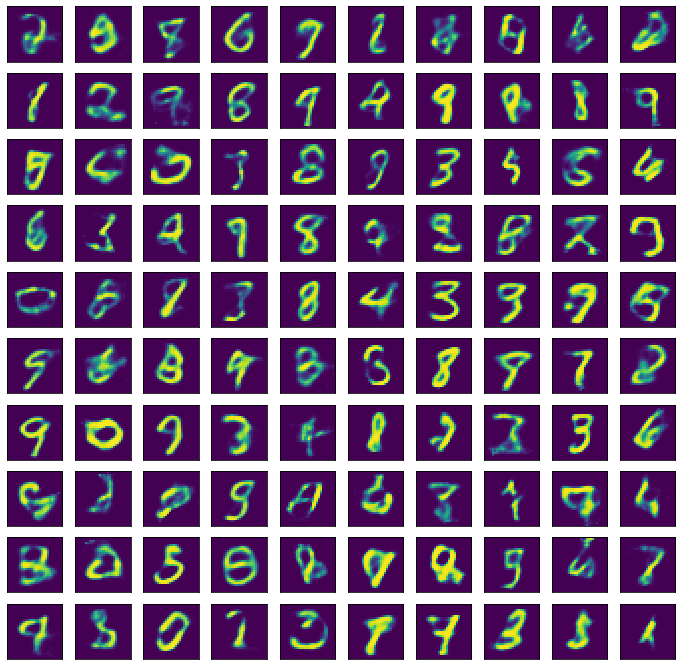

In [10]:
z = generate_(100).to(device)
generated_images = Variable(model.decode(z),requires_grad =False)
z= generated_images.reshape((100,28,28))
z=z.cpu().detach().numpy()
fig=plt.figure(figsize=(12, 12))

columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = z[i-1]
    fig.add_subplot(rows, columns,i)
    
    show = plt.imshow(img)
    show.axes.get_xaxis().set_visible(False)
    show.axes.get_yaxis().set_visible(False)
plt.savefig('result.jpg')
plt.show()